In [1]:
import lasagne
import numpy as np
import matplotlib.pyplot as plt
import unittest
import string
from theano import tensor as tnsr
from theano import function, shared
from hrf_fitting.src.feature_weighted_rf_models import receptive_fields
from hrf_fitting.src.features import make_space

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Class definitions + Unit tests

In [3]:
##convenience functions for getting/setting params by name

def get_model_params_names(l_model):
    p_names = [shared_var.name for shared_var in lasagne.layers.get_all_params(l_model)]
    return p_names

def set_named_model_params(l_model,**kwargs):
    for shared_var in lasagne.layers.get_all_params(l_model):
        if shared_var.name in kwargs.keys():
            shared_var.set_value(kwargs[shared_var.name])

def get_named_param_shapes(l_model, *args):
    param_shape_dict = {}
    for shared_var in lasagne.layers.get_all_params(l_model):
        if shared_var.name in args:
            try:
                param_shape_dict[shared_var.name] = shared_var.get_value().shape
                print 'parameter %s has shape %s' %(shared_var.name, param_shape_dict[shared_var.name])
            except AttributeError:
                print 'no shape attribute available for %s' %(shared_var.name)
    return param_shape_dict    


def get_named_params(l_model, *args):
    param_value_dict = {}
    for shared_var in lasagne.layers.get_all_params(l_model):
        if shared_var.name in args:
            param_value_dict[shared_var.name] = shared_var
    return param_value_dict
 

In [4]:
class TestGetSetShape(unittest.TestCase):
    def setUp(self):
        ##build some random complicated layer
        input_shape = (14, 13, 12, 12)
        num_units = 11
        self.test_layer = lasagne.layers.RecurrentLayer(input_shape,num_units)
    
    def test_param_set_get_shape(self):
        params = lasagne.layers.get_all_params(self.test_layer)
        for p in params:
            val = get_named_params(self.test_layer, p.name)[p.name]
            self.assertEqual(val.get_value().shape, get_named_param_shapes(self.test_layer, p.name)[p.name])
            
    def test_param_names(self):
        pnames = get_model_params_names(self.test_layer)
        self.assertEqual(pnames, [p.name for p in lasagne.layers.get_all_params(self.test_layer)])

suite = unittest.TestLoader().loadTestsFromTestCase( TestGetSetShape )
unittest.TextTestRunner(verbosity=1).run( suite )

..

parameter hid_init has shape (1, 11)
parameter input_to_hidden.W has shape (144, 11)
parameter input_to_hidden.b has shape (11,)
parameter hidden_to_hidden.W has shape (11, 11)



----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [5]:
class receptive_field_layer(lasagne.layers.Layer):
    '''
    receptive_field_layer(incoming, num_voxels, (X_grid, Y_grid), deg_per_stim, x0=None, y0=None, sig=None)
    
    --inputs
    incoming ~ should be an input layer with (T,D,S,S) input_var tensor4
    
    num_voxels  ~ V
    
    (X_grid, Y_grid) ~ numpy matrices of spatial 2D grid specified in pixels. output "make_space" or np.meshgrid
    
    when x0,y0,sig=None initializes each rf with (x0,y0)=(0,0), stdev = 1. otherwise, can initialize with a theano shared variable or numpy array
    
    creates a stack of 2D gaussian rf blobs. The stack has dimensions (V,S,S). just call "make_rf_stack()"
    
    application gives a tensor of shape (T,D,V) 
    
    --attributes
    params are [x0, y0, sig], which are the (x,y) coors and standard dev., resp., of the gaussian rfs
    for some set of voxels
    
    make_rf_stack() will construct a stack of visualizable rf's
    '''    
    def __init__(self, incoming, num_voxels, space_grid, deg_per_stim, x0=None, y0=None, sig=None, dtype='float32', **kwargs):
        super(receptive_field_layer, self).__init__(incoming, **kwargs)  ##this will give us an "input_shape" attribute
        self.S = self.input_shape[-1]
        self.V = num_voxels
        
        self.pix_per_deg = self.S * (1./deg_per_stim)  ##this will convert into pixels
        self.Xm = shared(space_grid[0].astype(dtype))  ##explicit casting. is there a better way to do this?
        self.Ym = shared(space_grid[1].astype(dtype))        
        
        if x0 is not None:
            self.x0 = self.add_param(x0,(self.V,), name='x0',rf_param=True,x0=True)
        else:
            self.x0 = self.add_param(np.zeros(self.V,dtype=dtype),(self.V,), name='x0',rf_param=True,x0=True)
        
        if y0 is not None:
            self.y0 = self.add_param(y0,(self.V,), name='y0',rf_param=True,y0=True)
        else:
            self.y0 = self.add_param(np.zeros(self.V,dtype=dtype),(self.V,), name='y0',rf_param=True,y0=True)
        
        if sig is not None:
            self.sig = self.add_param(sig,(self.V,), name='sig',rf_param=True,sig=True) 
        else:
            self.sig = self.add_param(np.ones(self.V,dtype=dtype),(self.V,), name='sig',rf_param=True,sig=True) 
        
        

        
        
        ##we put the pix_per_deg conversion here becuase x0,y0,sig will be shared across feature spaces
        #this expression has shape (V,S,S)
        self.gauss_expr = ((1. / 2*np.pi*(self.sig[:,np.newaxis,np.newaxis]*self.pix_per_deg)**2)
                           *tnsr.exp(-((self.Xm[np.newaxis,:,:]-self.x0[:,np.newaxis,np.newaxis]*self.pix_per_deg)**2
                                       + (self.Ym[np.newaxis,:,:]-self.y0[:, np.newaxis,np.newaxis]*self.pix_per_deg)**2)
                                     /(2*(self.sig[:,np.newaxis,np.newaxis]*self.pix_per_deg)**2)))
        
        self.make_rf_stack = function([],self.gauss_expr)
        
    
    #T,D,S,S x V,S,S --> T,D,V
    def get_output_for(self, input, **kwargs):
        return tnsr.tensordot(input, self.gauss_expr, axes=[[2,3],[1,2]])
    
    def get_output_shape_for(self, input_shape): ##(T,D,V)
        return (input_shape[0], input_shape[1], self.V)
    
    def set_value_for_voxel(self, voxel_idx=None, x0=None, y0=None, sig=None):
        if x0 is not None: ##we assume the shared variable has already been created and registered
            x0_temp = self.x0.get_value()
            x0_temp[voxel_idx] = x0
            self.x0.set_value(x0_temp)
        if y0 is not None:
            y0_temp = self.y0.get_value()
            y0_temp[voxel_idx] = y0
            self.y0.set_value(y0_temp)
        if sig is not None:
            sig_temp = self.sig.get_value()
            sig_temp[voxel_idx] = sig
            self.sig.set_value(sig_temp)
        
    
        

In [6]:
class TestRfLayer(unittest.TestCase):
    def setUp(self):
        self.T = 900
        self.D = 90
        self.S = 9
        self.input_shape = (self.T,self.D,self.S,self.S)
        self.V = 10
        self.deg_per_stim = 20
        #this tensor stores feature map
        self.f_map_0 = tnsr.tensor4('f_map_0',dtype='float32')
        ##construct an input layer
        self.input_layer = lasagne.layers.InputLayer(self.input_shape, input_var = self.f_map_0, name='input_layer')
        ##create a real numpy input of all 1's
        self.input_data = np.ones(self.input_shape,dtype='float32')
        
        try:
            self.rf_layer = receptive_field_layer(self.input_layer, self.V, make_space(self.S), self.deg_per_stim, name='rf_layer')
        except:
            print 'could not init rf layer'
    
    ##rf stack should be V,S,S
    def test_rf_layer_make_rf_stack(self):          
        self.assertEqual(self.rf_layer.make_rf_stack().shape, (self.V,self.S,self.S))
    
    ##output should be T,D,V
    def test_rf_layer_output_shape(self):
        output_shape = self.rf_layer.get_output_shape_for(self.input_shape)
        self.assertEqual(output_shape, (self.T,self.D,self.V))
    
    ##grid where rfs are evaluated
    def test_rf_layer_spatial_grid(self):
        self.assertEqual(self.rf_layer.Xm.get_value().shape, (self.S,self.S))
        self.assertEqual(self.rf_layer.Ym.get_value().shape, (self.S,self.S))
    
    ##should all be V
    def test_rf_layer_param_shapes(self):
        self.assertEqual(self.rf_layer.x0.get_value().shape, (self.V,))
        self.assertEqual(self.rf_layer.y0.get_value().shape, (self.V,))
        self.assertEqual(self.rf_layer.sig.get_value().shape, (self.V,))
    
    ##should be T,D,V
    def test_rf_layer_output_function_shape(self):
        rf_layer_expr = lasagne.layers.get_output(self.rf_layer)
        rf_layer_func = function([self.input_layer.input_var], rf_layer_expr)
        self.assertEqual(rf_layer_func(self.input_data).shape,(self.T,self.D,self.V))
        
    ##should go from 0 to 10
    def test_set_value_for_voxel(self):
        self.rf_layer.set_value_for_voxel(voxel_idx=-1,x0=10,y0=10,sig=10)
        self.assertEqual(self.rf_layer.x0.get_value()[-1],10)  ## this is same as next line
        self.assertEqual(get_named_params(self.rf_layer,self.rf_layer.x0.name)[self.rf_layer.x0.name].get_value()[-1],10)
        self.assertEqual(self.rf_layer.y0.get_value()[-1],10)
        self.assertEqual(self.rf_layer.sig.get_value()[-1],10)

suite = unittest.TestLoader().loadTestsFromTestCase( TestRfLayer )
unittest.TextTestRunner(verbosity=1).run( suite )        

......
----------------------------------------------------------------------
Ran 6 tests in 1.172s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [7]:
class compressive_nonlinearity_layer(lasagne.layers.Layer):
    '''
    a compressive function used in a previous publication. works well.
    requires all inputs to be positive, BUT DOES NOT CHECK!
    computes elementwise log(1+sqrt(input))
    '''
    def get_output_for(self, input, **kwargs):
        return tnsr.log(1+tnsr.sqrt(input))
    

In [8]:
class TestCompressiveNonlinearityLayer(unittest.TestCase):
    def setUp(self):
        self.T = 1001
        self.D = 101
        self.V = 11
        self.input_shape = (self.T,self.D,self.V)
        self.test_layer = compressive_nonlinearity_layer(self.input_shape)
    def test_output_shape(self):
        self.assertEqual(self.input_shape, self.test_layer.get_output_shape_for(self.input_shape))
 
suite = unittest.TestLoader().loadTestsFromTestCase( TestCompressiveNonlinearityLayer )
unittest.TextTestRunner(verbosity=1).run( suite )   

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [9]:
class normalization_layer(lasagne.layers.Layer):
    def __init__(self, incoming, mean=lasagne.init.Constant([0]), stdev=lasagne.init.Constant([1]), mask = lasagne.init.Constant([1]), **kwargs):
        super(normalization_layer,self).__init__(incoming, **kwargs)
        self.mean = self.add_param(mean, self.input_shape[1:], name='mean', trainable=False)
        self.stdev = self.add_param(stdev, self.input_shape[1:], name='stdev', trainable=False)
        self.stability_mask = self.add_param(mask, self.input_shape[1:], name='stability_mask', trainable=False)
    
    def get_output_for(self, input, **kwargs):
        return tnsr.switch(self.stability_mask>0, (input - self.mean[np.newaxis,:,:])/self.stdev[np.newaxis,:,:], 0)

In [10]:
class TestNormalizationLayer(unittest.TestCase):
    def setUp(self):
        self.T = 1001
        self.D = 4
        self.V = 2
        self.x = tnsr.tensor3('x')
        self.input_shape = (self.T,self.D,self.V)
        self.input_layer = lasagne.layers.InputLayer(self.input_shape, input_var=self.x, name='input_layer')
        self.test_input = np.random.random(size=self.input_shape).astype('float32')
        self.test_input[:,0,0] = 1.
        self.mean = np.mean(self.test_input, axis=0)
        self.std = np.std(self.test_input, axis=0)
        self.mask = np.ones((self.D,self.V))
        self.mask[0,0] = 0
        self.test_layer = normalization_layer(self.input_layer, mean=self.mean, stdev = self.std, mask = self.mask)
        
    def test_output_shape(self):
        self.assertEqual(self.input_shape, self.test_layer.get_output_shape_for(self.input_shape))
    
    def test_out_values(self):
        output_func = function([self.x], [lasagne.layers.get_output(self.test_layer)])
        y = output_func(self.test_input)[0]
        ##shape is right
        self.assertEqual(self.input_shape, y.shape)
        ##degenerate entry set to 0
        self.assertTrue(np.all(y[:,0,0]==0))
        ##mean is 0
        np.testing.assert_almost_equal(np.mean(y,axis=0), 0, decimal=5)
        ##stdev is 1 for all but degnerate entry
        np.testing.assert_almost_equal(np.std(y,axis=0).ravel()[1:], 1, decimal=6)


suite = unittest.TestLoader().loadTestsFromTestCase( TestNormalizationLayer )
unittest.TextTestRunner(verbosity=1).run( suite )           

..
----------------------------------------------------------------------
Ran 2 tests in 0.057s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [11]:
class feature_weights_layer(lasagne.layers.Layer):
    '''
    feature_weights_layer(incoming, NU = lasagne.init.Constant([0]))
       incoming ~ should be an rf space tensor (T,D,V)
             NU ~ (D, V) matrix of feature weights.
    output      ~ (T, V) matrix of predicted responses.
    '''    
    def __init__(self, incoming, NU = lasagne.init.Constant([0]), **kwargs):
        ##this will give us an "input_shape" attribute
        super(feature_weights_layer, self).__init__(incoming, **kwargs)  
        self.D = self.input_shape[1]
        self.V = self.input_shape[-1]
        self.feature_dim = 0
        self.voxel_dim = 1
        ##creates the theano shared variable
        self.NU = self.add_param(NU, (self.D, self.V), name='feature_weights', feature_weights=True) 
    
    def get_output_for(self, input, **kwargs):
        return (input*self.NU[np.newaxis,:,:]).sum(axis=1)
        
    def get_output_shape_for(self, input_shape): ##input_shape = (T, D, V)
        return (input_shape[0], self.V)
    
    ##if NU = None, this will do nothing and return None
    def set_weight_for_voxel(self, voxel_idx=None, NU=None):
        if NU is not None:
            NU_temp = self.NU.get_value()
            NU_temp[:,voxel_idx] = NU
            self.NU.set_value(NU_temp)
            

In [12]:
class TestFeatureWeightsLayer(unittest.TestCase):
    def setUp(self):
        T,D,V = 1001,4,20
        self.input_shape = (T,D,V)
        self.x = tnsr.tensor3('x')
        self.input_layer = lasagne.layers.InputLayer(self.input_shape, input_var=self.x, name='input_layer')
        self.test_input = np.random.random(size=self.input_shape).astype('float32')
        self.test_layer = feature_weights_layer(self.input_layer)
        self.layer_func = function([self.x], lasagne.layers.get_output(self.test_layer))
        self.y = self.layer_func(self.test_input)
    
    def test_output(self):
        self.assertEqual((self.input_shape[0], self.input_shape[-1]), self.test_layer.get_output_shape_for(self.input_shape))
        self.assertEqual((self.input_shape[0], self.input_shape[-1]), self.y.shape)
        
    def test_set_weight_for_voxel(self):
        self.assertIsNone(self.test_layer.set_weight_for_voxel(NU = None))
        voxel_idx = [0,1,-2,-1]
        NU = [1,1] ##this raise value error because of mismatch
        with self.assertRaises(ValueError):
            self.test_layer.set_weight_for_voxel(voxel_idx = voxel_idx, NU = NU)     
        NU = np.random.random((self.input_shape[1], len(voxel_idx))).astype('float32')
        self.test_layer.set_weight_for_voxel(voxel_idx = voxel_idx, NU=NU)
        np.testing.assert_array_equal(self.test_layer.NU.get_value()[:,voxel_idx], NU)

suite = unittest.TestLoader().loadTestsFromTestCase( TestFeatureWeightsLayer )
unittest.TextTestRunner(verbosity=1).run( suite )         

..
----------------------------------------------------------------------
Ran 2 tests in 0.066s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [13]:
x = np.zeros((10,4,2))
print x[0]
x[0] = np.ones((4,2))
print x[0]

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]


In [14]:
class lasagne_model_learner(object):
    
    def __init__(self,l_model, model_input_tnsr_dict, trn_data_generator, val_data_generator, epochs = 1, check_every=10, num_iters=10, learning_rate = 1.0,learn_these_params = None, voxel_dims = None, print_stuff=False):

        '''
        lasagne_model_learner(l_model,
                            model_input_tnsr_dict,
                            trn_data_generator,
                            val_data_generator,
                            epochs=1,
                            check_every=10,
                            num_iters=10,
                            learning_rate = 1.0,
                            learn_these_params = None,
                            voxel_dims = None)

        a class for doing cross-validated (stochastic) gradient descent on params of a lasagne model with many independent
        chanels (referred to as "voxels"). After each gradient step, checks each model independently, and updates it
        if gradient step reduces error on validation set.

        inputs:
                            l_model ~ a lasagne model with output shape (T,V), where T = #trials, V=#voxels
            model_input_tensor_dict ~ dict of theano tensors that are input to the l_model.
                 trn_data_generator ~ a generator of (input, output) training data batches. this is function that you have write.
                                      it should yield batches of data, i.e., trn_data_generator() will give you your training batches.
                                      the format for each batch is (input, output), where
                                      input = training input data dictionary. each key/value matches the names/dimensions of corresponding tensor in model_input_tensor_dict
                                      output = np.array of shape (Ttrn, V)
                 val_data_generator ~ generator for validation data
                             epochs ~ number of times through all data in the generator
                        check_every ~ int. how often validation loss is checked. default = 10
                          num_iters ~ number of gradient steps per batch before stopping. default = 100
                      learning_rate ~ size of gradient step. default = 1
                 learn_these_params ~ list of parameters names to learn, in case you don't want to train them all.
                                      default = None, meaning train all trainable params
                        voxel_dims  ~ dictionary, keys=param names, values = ints.
                                      for each learned parameter, this corresponds to the voxel dimension.
                                      default = None, in which case we try to figure out what the dimension is.
                                      if we can't, we complain, and you are forced to specify.
        outputs:
                     l_model ~ original l_model with params all trained up. this is a convenience, as params are learned in-place
                 trn_history ~ array of length num_iters showing number of voxels with decreased training loss at each time step
                 val_history ~ array of length num_iters showing number of voxels with decreased validation loss at each time step

        notes:
            we call each independent model a "voxel". but it could be anything. 

            the data_generator approach is very general/flexible. in the case where you can simply load up the whole training/validation
            data sets at once, it is just a slight encumberance, forcing you to define trn_data_generator() = yield trn_data.
            in many cases though, it will not be possible to load all the data at once, so this approach will be helpful.

            if trn_data_generator() contains only one large batch, epochs=1, and num_iters = BIG, we get standard grad. descent.
            if trn_data_generator() contains many mini-batches, epochs > 1, num_iters = 1, we get *stochastic* grad. descent.
        '''
        
        ##record all the inputs
        self.l_model = l_model
        
        self.model_input_tnsr_dict = model_input_tnsr_dict
        self.trn_data_generator = trn_data_generator
        self.val_data_generator = val_data_generator
        self.epochs = epochs
        self.check_every=check_every
        self.num_iters = num_iters
        self.learn_these_params = learn_these_params
        self.learning_rate = learning_rate
        self.print_stuff = print_stuff
        
        ##record/check data dimensions
        ##read first batches to get some dimensions 
        trn_in, trn_out = next(trn_data_generator()) 
        val_in, val_out = next(val_data_generator())
        trn_batch_size, num_trn_voxels = trn_out.shape  
        val_batch_size, num_val_voxels = val_out.shape    
        assert num_trn_voxels == num_val_voxels, "number of trn/val voxels don't match"
        self.num_voxels = num_trn_voxels

        ##check to make sure that all feature map stacks in the input dictionary have the same number of timepoints.
        ##this is not a complete check, since it's just the first batch, but if shit is not fucked up for this batch, 
        ##shit will hopefully not be fucked up for subsequent batches
        for k,v in trn_in.iteritems():
            assert v.shape[0] == trn_batch_size, "number of input/output trn trials don't match for feature %s" %(k)

        for k,v in val_in.iteritems():
            assert v.shape[0] == val_batch_size, "number of input/output val trials don't match for feature %s" %(k)


        ##get params (theano shared variables) to learn
        if learn_these_params is not None:            
            self.params = [v for v in get_named_params(l_model, *learn_these_params).values()] ##<<unpack the dict.
        else:
            self.params = lasagne.layers.get_all_params(l_model,trainable=True)
        print 'will solve for: %s' %(self.params)


        ##try to determine which dimension of each parameter is the voxel dimension
        if voxel_dims is None:
            self.voxel_dims = {}
            for p in self.params:
                ##the voxel dimension should be the one that matches "num_voxels"
                vdim = [ii for ii,pdim in enumerate(p.shape.eval()) if pdim==self.num_voxels]
 
                ##if we happen to have multiple dimensions that = "num_voxels", we need to use to disambiguate for us
                assert len(vdim)==1, "sorry, we can't determine voxel dimension for param %s. please supply explicit 'voxel_dims' argument" %p.name
                self.voxel_dims[p.name] = vdim[0]
        else:
            self.voxel_dims = voxel_dims


        ##create symbolic voxel activity tensor
        voxel_data_tnsr = tnsr.matrix('voxel_data_tnsr')  ##voxel data tensor: (T x V)

        ##get symbolic prediction expression
        pred_expr = lasagne.layers.get_output(l_model)  ##voxel prediction tensor: (T x V)

        ##generate symbolic loss expression
        trn_diff = voxel_data_tnsr-pred_expr  ##difference tensor: (T x V)
        loss_expr = (trn_diff*trn_diff).sum(axis=0) ##sum-sqaured-diffs tensor (V)

        ##construct update rule: note we sum the loss expression. 
        fwrf_update = lasagne.updates.sgd(loss_expr.sum(),self.params,learning_rate=learning_rate)

        ##compile loss and training functions
        print 'compiling...'
        self.loss = function([voxel_data_tnsr]+model_input_tnsr_dict.values(), loss_expr)
        self.trn_kernel = function([voxel_data_tnsr]+model_input_tnsr_dict.values(), loss_expr, updates=fwrf_update)        

    def learn(self):
        ##initialize parameter/loss
        best_param_values = [np.copy(p.get_value()) for p in self.params]
        val_loss_was = np.inf*np.ones(self.num_voxels)  ##start with infinite loss
        trn_loss_was = np.inf*np.ones(self.num_voxels)  ##start with infinite loss
        val_history = []
        trn_history = []
        
        ##descend and validate
        epoch_count = 0
        while epoch_count < self.epochs:
            print '=======epoch: %d' %(epoch_count) 
            for trn_in, trn_out in self.trn_data_generator():
                step_count = 0
                while step_count < self.num_iters:
                    trn_loss_is = self.trn_kernel(trn_out, *trn_in.values()) 
                    
                    if step_count % self.check_every == 0:

                        ##check for improvements
                        val_loss_is = 0
                        for val_in, val_out in self.val_data_generator():
                            val_loss_is += self.loss(val_out, *val_in.values())
                        improved = np.where(val_loss_is < val_loss_was)[0]

                        ##update val loss
                        val_loss_was[improved] = val_loss_is[improved]

                        ##replace old params with better params
                        for ii,p in enumerate(self.params):
                            vdim = self.voxel_dims[p.name]   ##the voxel dimension
                            s = [slice(None),]*p.ndim   ##create a slicing object with right number of dims
                            s[vdim] = improved          ##assign improved voxel indices to the correct dim of the slice object
                            best_param_values[ii][s] = np.copy(p.get_value()[s])   ##keep a record of the best params.

                        ##report on loss history
                        trn_improved = trn_loss_is < trn_loss_was
                        val_history.append(len(improved))
                        trn_history.append(np.sum(trn_improved))
                        if self.print_stuff:
                            print '====iter: %d' %(step_count)
                            print 'improvements val: %d' %(val_history[-1])
                            print 'improvements trn: %d' %(trn_history[-1])
                    
                    step_count += 1

            epoch_count += 1

        ##restore best values of learned params
        set_named_model_params(self.l_model, **{k.name:v for k,v in zip(self.params, best_param_values)})
       

        return self.l_model, val_history, trn_history

In [15]:
0 % 10

0

In [16]:
class TestLasagneModelLearner(unittest.TestCase):
    
    def setUp(self):
        Ttrn,Tval,D,S,V = 5000,200,5,2,3
        self.V = V
        self.Ttrn = Ttrn
        self.Tval = Tval
        model_input_tnsr_dict = {}
        model_input_tnsr_dict['fmap0'] = tnsr.tensor4('fmap0')
        input_layer = lasagne.layers.InputLayer((None,D,S,S), input_var = model_input_tnsr_dict['fmap0'])
        
        self.true_W = np.random.random((D*S*S,V)).astype('float32')
        true_model = lasagne.layers.DenseLayer(input_layer,num_units = V, W=self.true_W)
        out_func = function([model_input_tnsr_dict['fmap0']], lasagne.layers.get_output(true_model))
        
        ##create training/val data using true model
        trn_in = {}
        trn_in['fmap0'] = np.random.random((Ttrn,D,S,S)).astype('float32')
        trn_out = out_func(trn_in['fmap0'])
        trn_data_gen = lambda: (yield trn_in, trn_out)
        val_in = {}
        val_in['fmap0'] = np.random.random((Tval,D,S,S)).astype('float32')
        val_out = out_func(val_in['fmap0'])
        val_data_gen = lambda: (yield val_in,val_out)
        
        ##test basic dimensions, parameter assignment
        self.learn_nothing = lasagne_model_learner(true_model, model_input_tnsr_dict,trn_data_gen, val_data_gen)
        
        ##test learning of "b": start at b=1, see if it will learn b = 0
        test_b_model = lasagne.layers.DenseLayer(input_layer,num_units = V, W=self.true_W, b=np.ones((self.V,)).astype('float32'))
        self.learn_b = lasagne_model_learner(test_b_model, model_input_tnsr_dict,trn_data_gen, val_data_gen, learn_these_params=['b'], check_every=100,learning_rate= 0.00001, num_iters = 400,print_stuff=False)

        ##test learning of "W": start at W = some other random values
        test_W_model = lasagne.layers.DenseLayer(input_layer,num_units = V, W=np.random.random((D*S*S,V)).astype('float32'))
        self.learn_W = lasagne_model_learner(test_b_model, model_input_tnsr_dict,trn_data_gen, val_data_gen, learn_these_params=['W'], check_every=100,learning_rate= 10e-15, num_iters = 90000, print_stuff=False)
        
        ##test learning of "W" and "b"
        test_both_model = lasagne.layers.DenseLayer(input_layer,num_units = V, W=np.random.random((D*S*S,V)).astype('float32'),b=np.ones((self.V,)).astype('float32'))
        self.learn_both = lasagne_model_learner(test_both_model, model_input_tnsr_dict,trn_data_gen, val_data_gen, check_every=100,learning_rate= 0.00001, num_iters = 15000, print_stuff=False)
 
    def test_num_voxels(self):
        self.assertEqual(self.learn_nothing.num_voxels, self.V)
    
    def test_voxel_dims(self):
        self.assertDictEqual(self.learn_nothing.voxel_dims, {'W': 1, 'b':0})        
        
    def test_loss_func(self):
        trn_in,trn_out = self.learn_nothing.trn_data_generator().next()
        trn_loss = self.learn_nothing.loss(trn_out,*trn_in.values())
        self.assertEqual(trn_out.shape, (self.Ttrn, self.V))
        self.assertEqual(trn_loss.shape, (self.V,))
        np.testing.assert_array_equal(trn_loss, np.zeros((self.learn_nothing.num_voxels,)))
    
    def test_learn_b(self):
        new_model,val_hist,trn_hist = self.learn_b.learn()
        np.testing.assert_array_almost_equal(new_model.b.get_value(), np.zeros((self.V)), decimal=5)
        
    def test_learn_W(self):
        new_model,val_hist,trn_hist = self.learn_W.learn()
        np.testing.assert_array_almost_equal(new_model.W.get_value(), self.true_W, decimal=5)
    
    def test_learn_both(self):
        new_model,val_hist,trn_hist = self.learn_both.learn()
        np.testing.assert_array_almost_equal(new_model.b.get_value(), np.zeros((self.V)), decimal=4)
        np.testing.assert_array_almost_equal(new_model.W.get_value(), self.true_W, decimal=4)
        
        
suite = unittest.TestLoader().loadTestsFromTestCase( TestLasagneModelLearner )
unittest.TextTestRunner(verbosity=1).run( suite )                

will solve for: [W, b]
compiling...
will solve for: [b]
compiling...
will solve for: [W]
compiling...
will solve for: [W, b]
compiling...
=======epoch: 0

.


will solve for: [W, b]
compiling...
will solve for: [b]
compiling...
will solve for: [W]
compiling...
will solve for: [W, b]
compiling...
=======epoch: 0

.


will solve for: [W, b]
compiling...
will solve for: [b]
compiling...
will solve for: [W]
compiling...
will solve for: [W, b]
compiling...
=======epoch: 0

.


will solve for: [W, b]
compiling...
will solve for: [b]
compiling...
will solve for: [W]
compiling...
will solve for: [W, b]

.


compiling...
will solve for: [W, b]
compiling...
will solve for: [b]
compiling...
will solve for: [W]
compiling...
will solve for: [W, b]

.


compiling...
will solve for: [W, b]
compiling...
will solve for: [b]
compiling...
will solve for: [W]
compiling...
will solve for: [W, b]

.


compiling...



----------------------------------------------------------------------
Ran 6 tests in 101.152s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [17]:
##merges multiple feature map stacks, applies receptive field layer, and whatever else you want.
class rf_model_space(object):
    '''  
       
    rf_model_space( feature_map_dict, deg_per_stim, num_voxels, rf_init={x0:array, y0:array, sig:array})
    
    The foundation for constructing a fwrf model. Creates receptive fields for a set of num_voxel voxels.
    
    inputs:
    feature_map_dict ~ dictionary of (T,D_i,S_i,S_i) feature maps. T can be 1. These values are not stored, they
                       are just used get basic name/dimension information for each kind of feature map.
        deg_per_stim ~ for the rf_layer, so that we can interpret things if deg. of visual angle
          num_voxels ~ the number of voxels
             rf_init ~ optional initial receptive field params for each voxels. 
                       must be a dictionary like {x0:x0_array, y0:y0_array, sig:sig_array}, where len(??_array)=num_voxels
    
    attributes:
        feature_depth
        feature_indices
        feature_resolutions
        D
        deg_per_stim
        num_voxels
        input_var_dict
        rf_layer ~ lasagne layer. good for accessing rf parameters
        rf_model_space ~ lasagne layer
        construct_model_space_tensor(feature_map_dict) ~ method
        normalize(calibration_data_generator, epsilon=10e-6, unstable=10e-10) ~ method
    
    
    merges multiple feature map stacks, applies receptive field layer, creates a dictionary of input tensors
    corresponding to each feature map stack, and creates an "rf_layer" attribute for convenient access to rf
    parameters.
    
    normalization: call it once using training data, it computes the -mean/stdev, adds a normalization layer,
                   and then sets the weights.
    
    does not apply the feature_weights layer. too many different branches after rf application for that to be useful.
    
    
    '''
    
    
    def __init__(self, feature_map_dict, deg_per_stim, num_voxels, rf_init=None):
        
        ##record and store basic properties of the feature maps
        self.feature_depth = {}
        self.feature_indices = {}
        self.feature_resolutions = {}
        idx = 0
        for f_key in feature_map_dict.keys():
            self.feature_depth[f_key] = feature_map_dict[f_key].shape[1]
            self.feature_indices[f_key] = np.arange(idx,idx + self.feature_depth[f_key],step=1)
            idx += self.feature_depth[f_key]
            self.feature_resolutions[f_key] = feature_map_dict[f_key].shape[2]
        
        ##total feature depth
        self.D = np.sum(self.feature_depth.values())
        
        ##rf properties
        self.deg_per_stim = deg_per_stim
        self.num_voxels = num_voxels
        if rf_init is None:
            rf_init = {}
            rf_init['x0'] = np.zeros(num_voxels,dtype='float32')
            rf_init['y0'] = np.zeros(num_voxels,dtype='float32')
            rf_init['sig'] = np.ones(num_voxels,dtype='float32')
        
            
    
        ##construct model space : applies rf's to feature maps
        '''
        each dict value is a (T,D_i,S_i,S_i) stack of feature maps, where i indexes each stack of feature maps
        each model space in the list will have output shape (T,D_i,V)
        will concatenate along axis 1 (= D)
        will share x0,y0,sig (the rf params) across feature spaces
        '''
        rf_space_list = []
        self.input_var_dict = {}
        for f_map_name in feature_map_dict.keys():
            
            ##get S_i x S_i
            input_shape = (None,)+feature_map_dict[f_map_name].shape[1:]

            self.input_var_dict[f_map_name] = tnsr.tensor4(f_map_name)

            ##the rf_layer for the first feature map
            l1 = lasagne.layers.InputLayer(input_shape, input_var = self.input_var_dict[f_map_name], name='input_'+f_map_name)
            
            ##the points in 2D space where rf will be evaluated 
            Xm,Ym = make_space(input_shape[-1])
            
            ##only one feature map stack or the first map stack:
            if not rf_space_list:  
                self.rf_layer = receptive_field_layer(l1,num_voxels,(Xm,Ym),deg_per_stim,x0=rf_init['x0'], y0=rf_init['y0'], sig=rf_init['sig'],name='rf_'+f_map_name)
                rf_space_list.append(self.rf_layer)
            else: ##rf centers/sizes will be shared
                rf_space_list.append(receptive_field_layer(l1,num_voxels,(Xm,Ym),deg_per_stim,
                                                              x0=self.rf_layer.x0,
                                                              y0=self.rf_layer.y0,
                                                              sig=self.rf_layer.sig,
                                                              name='rf_'+f_map_name))
    
        self.rf_model_space = lasagne.layers.ConcatLayer(rf_space_list,axis=1, name='rf_model_space')
        
        self.construct_model_space_tensor = function(self.input_var_dict.values(), lasagne.layers.get_output(self.rf_model_space))
    
    def normalize(self, calibration_data_generator, epsilon=0., unstable=10e-10):
        mst = []
        for cal_map in calibration_data_generator():
            mst.append(self.construct_model_space_tensor(*cal_map.values()))
        mst = np.concatenate(mst,axis=0)
        mn = np.mean(mst,axis=0)
        stdev = np.std(mst, axis=0)+epsilon
        stability_mask = (stdev > unstable).astype('float32')
        self.rf_model_space = normalization_layer(self.rf_model_space, mean=mn, stdev=stdev, mask=stability_mask)
        self.epsilon=epsilon
        self.unstable=unstable
        self.construct_model_space_tensor = function(self.input_var_dict.values(), lasagne.layers.get_output(self.rf_model_space))
        

In [18]:
class TestRfModelSpace( unittest.TestCase ):
    
    def setUp(self):
        T,D,V = 20,13,3
        self.V = V
        self.nmaps = 10
        self.D = D
        self.T = T
        self.deg_per_stim = 10
        self.feature_map_dict = {}
        ##create 10 feature maps where resolution happens to be name
        for ii in range(1,self.nmaps+1):
            input_name = 'fmap_%0.2d' % (ii)
            self.feature_map_dict[input_name] = np.random.random((T,D,ii,ii)).astype('float32')
        
        self.rfms = rf_model_space(self.feature_map_dict, self.deg_per_stim, self.V)
        
        self.cal_data_generator = lambda: (yield self.feature_map_dict)
    
    def test_basic_attributes(self):
        self.assertEqual(self.rfms.D, self.D*self.nmaps)
    
    def test_construct_model_space_tensor(self):
        mst = self.rfms.construct_model_space_tensor(*self.feature_map_dict.values())
        self.assertEqual(mst.shape, (self.T, self.rfms.D, self.V))
        
    def test_normalize(self):
        self.rfms.normalize(self.cal_data_generator)
        mst = self.rfms.construct_model_space_tensor(*self.feature_map_dict.values())
        np.testing.assert_array_almost_equal(np.mean(mst,axis=0), np.zeros((self.rfms.D,self.V)), decimal=6)
        np.testing.assert_array_almost_equal(np.std(mst,axis=0), np.ones((self.rfms.D,self.V)), decimal=6)

suite = unittest.TestLoader().loadTestsFromTestCase( TestRfModelSpace )
unittest.TextTestRunner(verbosity=1).run( suite )                        

...
----------------------------------------------------------------------
Ran 3 tests in 14.116s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [ ]:
##a fwrf model
class fwrf(rf_model_space):
    
   '''
   fwrf(feature_map_dict, deg_per_stim, num_voxels, rf_init=None, bonus_layers=None)
   
   Creates a fwrf model for multiple voxels.
   
    inputs:
    feature_map_dict ~ dictionary of (T,D_i,S_i,S_i) feature maps. T can be 1. These values are not stored, they
                       are just used get basic name/dimension information for each kind of feature map.
        deg_per_stim ~ for the rf_layer, so that we can interpret things if deg. of visual angle
          num_voxels ~ the number of voxels
             rf_init ~ optional initial receptive field params for each voxels. 
                       must be a dictionary like {x0:x0_array, y0:y0_array, sig:sig_array}, where len(??_array)=num_voxels
        bonus_layers ~ a callable stack of layers that accepts an incoming layer. if supplied, the rf_model_space
                       lasagne model is treated as incoming to the bonus layer. a feature_weights_layer is then applied.
                       if not supplied, a feature_weights_layer is added directly to rf_model_space.
            
       
   '''
    
    def __init__(self, feature_map_dict, deg_per_stim, num_voxels, rf_init=None, bonus_layers=None):
        super(fwrf, self).__init__(feature_map_dict, deg_per_stim, num_voxels, rf_init)
        if bonus_layers:
            self.stack_feature_layers = lambda x: feature_weights_layer(bonus_layers(x))
        else:
            self.stack_feature_layers = lambda x: feature_weights_layer(x)
            
        self.fwrf = self.stack_feature_layers(self.rf_model_space)
        
        
        self.pred_expr = lasagne.layers.get_output(self.fwrf)
        
        ##this gives predicted output as (T,V) tensor
        self.predicted_activity = function(self.input_var_dict.values(), self.pred_expr)
        
    
    trn_data_generator, 
    val_data_generator, 
    epochs = 1, 
    check_every=10, 
    num_iters=10, 
    learning_rate = 1.0,
    learn_these_params = None, 
    voxel_dims = None, 
    print_stuff=False
    
    def train_me(self, trn_data_generator, val_data_generator, rf_grid=None, **kwargs):
        if 'coarse' in kwargs.keys() && kwargs['coarse']:
            assert rf_grid is not None, 'if you are running coarse learning, you must supply an rf_grid'         
            
            ##a generator of model space tensors that iterates over T
            trn_data_gen,input_shape = self._build_rf_model_space_tensor(trn_data_generator, rf_grid)
            
            ##same as a above, but for training data
            val_data_gen = self._build_rf_model_space_tensor(val_data_generator, rf_grid)
            
            
            ##a new network that treats everything up to the feature weights as input
            proxy_net, proxy_input_var_dict = self._build_proxy_network(rf_grid)
            
            ##learn the best rf+feature_weights
            proxy_net,val_history,trn_history = lasagne_model_learner(proxy_net, proxy_input_var_dict, trn_data_gen, val_data_gen, **kwargs).learn()
            params = self._get_best_proxy_net_params(proxy_net, rf_grid)
            
            ##assign best params to network
            lasagne.layers.set_all_params(self.fwrf, params)
            
            ##free up memory allocated to proxy network?
            
        elif ('fine' not in kwargs.keys()) or kwargs['fine']:
            assert rf_grid is None, "don't pass an rf grid if you are fine-tuning"
            self.fwrf,val_history, trn_history = lasagne_model_learner(self.fwrf, self.input_var_dict, trn_data_generator, val_data_generator, **kwargs).learn()
    
    
    
    def _build_proxy_network(self, input_shape):
        #check fwrf, get shape
        #make a new network with an input layer and feature layer only
        proxy_input_var_dict = {}
        proxy_input_var_dict['mst'] = tnsr.tensor4('mst')
        proxy_net = lasagne.layers.InputLayer((None,)+input_shape[1:]), input_var = proxy_input_var_dict['mst'])
        proxy_net = feature_weights_layer(proxy_net)
        return proxy_net, proxy_input_var_dict
        
    
    def _build_rf_model_space_tensor(self, data_gen, rf_grid):
        data_example = data_gen().next
        proxy_rf_model_space = rf_model_space(data_example, self.deg_per_stim, self.num_voxels,rf_init=rf_grid)
        mst = []
        for fmap in data_gen():
            mst.append(proxy_rf_model_space.construct_model_space_tensor(*fmap.values()))
        mst = np.concatenate(mst,axis=0)
        mst_shape = mst.shape
        mst = lambda: (yield mst)
        #options:
        # 1) use rf_model_space layer to create a new data generator 
        # 2) loop over all items in the data_generator, make one big brick, package as degenerate generator (heh)
        return mst, mst_shape ##a generator

    
    def _get_best_proxy_net_params(proxy_net, val_data_gen, rf_grid):
        ##final_loss = SOME_LOSS_FUNCTION(proxy_net,val_data_gen)
        ##min_loss_arg = arg_min(final_loss, voxel_dim)
        ##params= {}
        ##params[feature_weights] = proxy_net.NU.get_value()[min_loss_arg]
        ##params[rf blah] = rf_grid[min_loss_arg] <<something like this
        ##return params
        
        
    
    
    def normalize(self, *args, **kwargs):
        ##call the model_space method
        super(fwrf, self).normalize(*args, **kwargs)
        ##then overwrite the feature layer
        self.fwrf = self.stack_feature_layers(self.rf_model_space)
               
    


In [26]:
rf_model_space

(None, 1, 2, 3)

In [ ]:
##TODO: INPUTS AS SHARED VARIABLES?
def decode_feature_maps(trn_fwrf_model, val_fwrf_model, trn_activity, val_activity, init_feature_map_dict, error_diff_thresh):
    ##build loss
    trn_activity_tensor = blarg
    val_activity_tensor = blarg
    trn_diff = trn_activity_tensor-trn_fwrf_model.pred_expr  ##difference tensor: (T x V)
    trn_loss_expr = (trn_diff*trn_diff).sum(axis=1) ##sum-sqaured-diffs tensor

    val_diff = val_activity_tensor-val_fwrf_model.pred_expr  ##difference tensor: (T x V)
    val_loss_expr = (val_diff*val_diff).sum(axis=1) ##sum-sqaured-diffs tensor

    ##build gradient w.r.t. input vars
    grad_expr = tnsr.gradient(trn_loss_expr, wrt=trn_fwrf_model.input_var_dict.values())
    
    grad_func = function([trn_activity_tensor]+trn_fwrf_model.input_var_dict.values(), grad_expr)
    
    val_loss_is = np.inf
    val_loss_was = np.inf
    
    err_diff = np.abs(val_loss_is - val_loss_was)
    
    new_map = np.copy(init_feature_map_dict)
    
    while err_diff < err_diff_thresh:
        
        new_map += learning_rate*grad_func(trn_activiy, **new_map)

In [ ]:
####===================ORPHANAGE=========================

In [ ]:
import string

In [15]:
T = 256 ##trials
D = [61, 62, 63] ##features
S = [11, 12, 13]
nmaps = len(D)
map_names = string.uppercase[:nmaps]
V = 100 ##voxels
deg_per_stim = 20

In [29]:
class MakeSpaceTest(unittest.TestCase):
    def test_make_space(self):
        pass

In [27]:
class fwrfTest(unittest.TestCase):
    
    def setUp(self):
        
        #testing of individual layers done with first feature map
        #testing of rf_model_space and fwrf done with full feature map dict.
        
        #--feature maps
        self.feature_map_dict = {key: val for key,val in zip(map_names, [np.random.rand(T,D[ii],S[ii],S[ii]) for ii in range(nmaps)])}
        self.means = [np.mean(self.feature_map_dict[key],axis=0) for key in self.feature_map_dict.keys()]
        self.stds = [np.std(self.feature_map_dict[key],axis=0) for key in self.feature_map_dict.keys()]
        self.masks = [np.random.randint(0,2,size=(T,D[ii],S[ii],S[ii])) for ii in range(nmaps)]
        
        #--input
        self.input_shape = (T,D,S[0],S[0])
        #this tensor stores feature map
        self.f_map_0 = tnsr.tensor4('f_map_0',dtype='float32')

        #--layers
        self.layers = {}
        self.output_shapes = {}
    
    def test_input_layer_init(self):    
        #the lasagne input layer
        self.layers['layer_1'] = lasagne.layers.InputLayer(self.input_shape, input_var = self.f_map_0, name='layer_1')
        #should not change output shape
        self.output_shapes['layer_1'] = self.layers['layer_1'].get_output_shape_for(self.input_shape)
        self.assertEqual(self.output_shapes['layer_1'], self.input_shape)
    

    def test_act_layer_init(self):
        #--activation layber
        self.layers['act_layer'] = compressive_nonlinearity_layer(self.layers['rf_layer'],name='act_layer')
        self.output_shapes['act_layer'] = self.layers['act_layer'].get_output_shape_for(self.output_shapes['rf_layer'])
        self.assertEqual(self.output_shapes['act_layer'], self.output_shapes['rf_layer']) ##should not change shape
    
    def test_norm_layer_init(self):
        #--norm layer
        self.layers['norm_layer'] = normalization_layer(self.layers['act_layer'], mean=self.means[0], stdev=self.stds[0], mask = self.masks[0], name='norm_layer')
        self.output_shapes['norm_layer'] = self.layers['norm_layer'].get_output_shape_for(self.output_shapes['act_layer'])
        self.assertEqual(self.output_shapes['norm_layer'], self.output_shapes['act_layer']) ##should not change shape
    
    def feature_layer_init(self):
        #--feature layer
        self.layers['feature_layer'] = feature_weights_layer(self.layers['norm_layer'])
        self.output_shapes['feature_layer'] = self.layers['feature_layer'].get_output_shape_for(self.output_shapes['norm_layer'])
        self.assertEqual(self.output_shapes['feature_layer'], (T,V))
    
    def tearDown(self):
        for s in self.output_shapes:
            print s
    
    
    def test_rf_layer(self):
        pass
    
    def test_norm_layer(self):
        pass
    
    def test_modelspace(self):
        pass
    
    def test_feature_weights_layer(self):
        pass
    
    def test_fwrf_init(self):
        pass
    
    def test_learn_lasagne_model(self):
        pass
    
    def test_fwrf_train_me_coarse(self):
        pass
    
    def test_fwrf_train_me_fine(self):
        pass
    
    def test_fwrf_decode(self):
        pass

In [ ]:
##rf layer unittest
def setUp(self):
        
        #testing of individual layers done with first feature map
        #testing of rf_model_space and fwrf done with full feature map dict.
        
        #--feature maps
        self.feature_map_dict = {key: val for key,val in zip(map_names, [np.random.rand(T,D[ii],S[ii],S[ii]) for ii in range(nmaps)])}
        self.means = [np.mean(self.feature_map_dict[key],axis=0) for key in self.feature_map_dict.keys()]
        self.stds = [np.std(self.feature_map_dict[key],axis=0) for key in self.feature_map_dict.keys()]
        self.masks = [np.random.randint(0,2,size=(T,D[ii],S[ii],S[ii])) for ii in range(nmaps)]
        
        #--input
        self.input_shape = (T,D,S[0],S[0])
        #this tensor stores feature map
        self.f_map_0 = tnsr.tensor4('f_map_0',dtype='float32')

        #--layers
        self.layers = {}
        self.output_shapes = {}
    
    def test_input_layer_init(self):    
        #the lasagne input layer
        self.layers['layer_1'] = lasagne.layers.InputLayer(self.input_shape, input_var = self.f_map_0, name='layer_1')
        #should not change output shape
        self.output_shapes['layer_1'] = self.layers['layer_1'].get_output_shape_for(self.input_shape)
        self.assertEqual(self.output_shapes['layer_1'], self.input_shape)

TypeError: issubclass() arg 1 must be a class

In [921]:
        
#     def _build_trn_pred(self):
#         self.trn_pred_expr = lasagne.layers.get_output(self.fwrf)
#         #self.trn_pred_func = function(self.input_var_dict.values(), self.trn_pred_expr)
    
#     def _build_val_pred(self):
#         ##this will make predictions using the current normalization params (i.e., since the last call of trn_pred_func)
#         self.val_pred_expr = lasagne.layers.get_output(self.fwrf, deterministic='True')
#         ##FUNCTION
#         self.predicted_activity = function(self.input_var_dict.values(), self.val_pred_expr)
        
#     def _build_trn_loss(self):
#         ##training loss expression: same as above except for the last summing step. so:
#         trn_diff = self.voxel_data_tnsr.T[:,:,np.newaxis]-self.trn_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
#         self.trn_loss_expr = (trn_diff*trn_diff).sum(axis=1).sum() ##sum-sqaured-diffs tensor: V x 1
    
#     def _build_val_loss(self): 
#         ##validation loss
#         val_diff = self.voxel_data_tnsr.T[:,:,np.newaxis]-self.val_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
#         self.val_loss_expr = (val_diff*val_diff).sum(axis=1) ##sum-sqaured-diffs tensor: V x 1
#         ##FUNCTION
#         self.loss = function([self.voxel_data_tnsr]+self.input_var_dict.values(), self.val_loss_expr)

        
        
              

#### How to build an input layer

In [49]:
####input shape
input_shape = (T,D,S,S)
####this tensor stores feature map
f_map_0 = tnsr.tensor4('f_map_0',dtype='float32')  ##(T,D,S,S)

####the lasagne input layer
layer_1 = lasagne.layers.InputLayer(input_shape, input_var = f_map_0, name='layer_1')

#### Test the rf layer
Output will have model-space tensor dimensions. 

In [52]:
G = 48
deg_per_stim = 20

In [53]:

rf_layer = receptive_field_layer(layer_1, G, make_space(S), deg_per_stim)

##### see initial stack of rfs -- they are all the same

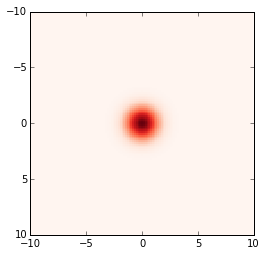

In [78]:
extent=[-deg_per_stim/2.,deg_per_stim/2.,deg_per_stim/2.,-deg_per_stim/2.]
plt.imshow(rf_layer.make_rf_stack()[-1,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)

##### but now change them, and re-view them
NOTE: everytyhing is specified in degrees.


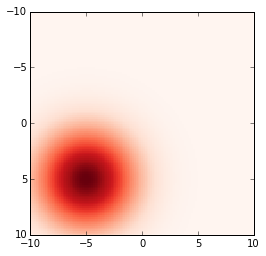

In [15]:
rf_layer.x0.set_value(-5*np.ones(G).astype('float32'))
rf_layer.y0.set_value(5*np.ones(G).astype('float32'))
rf_layer.sig.set_value(3*np.ones(G).astype('float32'))
plt.imshow(rf_layer.make_rf_stack()[3,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)

##### compile output function, test shape

In [16]:
prediction = lasagne.layers.get_output(rf_layer)
pred_func = function([layer_1.input_var], prediction)

In [17]:
outp = pred_func(np.zeros(input_shape).astype('float32'))
print outp.dtype
print outp.shape

float32
(48, 256, 64)


##### check out the params

In [18]:
lasagne.layers.get_all_params(rf_layer)

[x0, y0, sig]

#### Test the activation layer
For the gabor model, we sometimes use the log(1+sqrt(x)) transforms. Here's that:

In [54]:
act_layer = compressive_nonlinearity_layer(rf_layer)

In [20]:
lasagne.layers.get_all_params(act_layer)

[x0, y0, sig]

In [21]:
l_3 = lasagne.layers.get_output(act_layer)
l_3_func = function([layer_1.input_var], l_3)

In [22]:
l_3_func(np.zeros(input_shape).astype('float32')).shape

(48, 256, 64)

#### Normalization layer
    pass deterministic=False for training
    pass deterministic=True for validation
    in our case output shape = (G,T,D), so normalization must integrate over axis=1
    this will give mean/stdev/gamma/beta params of shape (G,D)

In [79]:
norm_layer = lasagne.layers.BatchNormLayer(rf_layer, axes=(1,))

In [80]:
print norm_layer.mean.get_value().shape
print norm_layer.inv_std.get_value().shape
print norm_layer.gamma.get_value().shape
print norm_layer.beta.get_value().shape

(48, 64)
(48, 64)
(48, 64)
(48, 64)


##### so everytime you call the layer_4 output function the mean/stdev params are updated.
but if you call with deterministic='True', the mean/stdev are not updated, they are fixed.

In [82]:
norm_pred_expr = lasagne.layers.get_output(norm_layer)
norm_pred_func = function([layer_1.input_var], norm_pred_expr)

In [88]:
x = np.random.random(size=input_shape).astype('float32')
_=norm_pred_func(x)
before= norm_layer.mean.get_value()
for _ in range(10):
    x = np.random.random(size=input_shape).astype('float32')
    um=norm_pred_func(x)
after = norm_layer.mean.get_value()

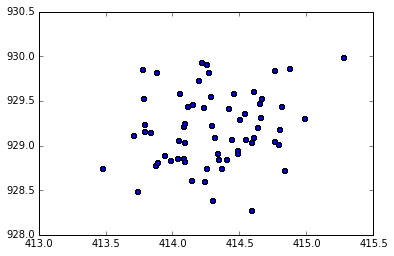

In [89]:
plt.scatter(before,after)
# lims = [np.min(after), np.max(after)]
# plt.xlim(lims)
# plt.ylim(lims)

...call layer_4 output function with deterministic='Trure' in a loop, and means are updated stay fixed

In [90]:
norm_pred_expr_fixed = lasagne.layers.get_output(norm_layer, deterministic = 'True')
norm_pred_func_fixed = function([layer_1.input_var], norm_pred_expr_fixed)

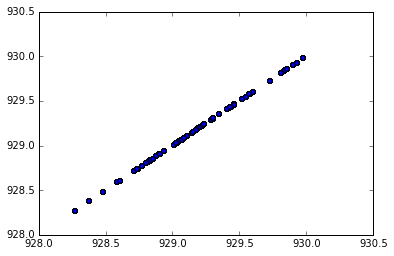

In [91]:
before= norm_layer.mean.get_value()
for _ in range(10):
    x = np.random.random(size=input_shape).astype('float32')
    _=norm_pred_func_fixed(x)
after = norm_layer.mean.get_value()
plt.scatter(before,after)

#### Feature weights layer


In [92]:
layer_5 = feature_weights_layer(norm_layer,1)

In [93]:
layer_5_pred_expr = lasagne.layers.get_output(layer_5)

In [94]:
layer_5_pred_func = function([layer_1.input_var],layer_5_pred_expr)

In [95]:

layer_5_pred_func(x).shape

(48, 256, 1)

#### Putting it all together
Usually we'll have multiple features spaces, where each feature space is a stack of feature maps with the same 
resolution.  
Because resolution can vary, we'll need construct separate rf layers for each feature space.  
Then, we can merge the feature spaces, and apply whatever normalization, nonlinearity, etc. we want before apply the feature weights.

##### construct feature space dictionary

In [166]:
feature_map_names = ['a','b','c']
feature_map_dict = {}
feature_depths = [12, 45, 78]
for fmap,fdep in zip(feature_map_names,feature_depths):
    feature_map_dict[fmap] = np.random.random(size=(T,fdep,S,S)).astype('float32')

num_rfs = 10

In [167]:
##construct model space
input_var_dict, model_space = make_fwrf_model_space(feature_map_dict, num_rfs, deg_per_stim)

test the model space part

In [168]:
print model_space.get_output_shape_for([input_shape])

model_space_pred_expr = lasagne.layers.get_output(model_space)
model_space_pred_func = function(input_var_dict.values(), model_space_pred_expr)

(256, 64, 125, 125)


In [172]:
lasagne.layers.get_all_params(model_space,rf_param=True)

[rf_a.x0, rf_a.y0, rf_a.sig]

In [173]:
print model_space_pred_func(*feature_map_dict.values()).shape
print sum(feature_depths)

(10, 256, 135)
135


check the parameters

### Two ways to train

**Method 1**: Grid search over many rfs for each voxel. In this case we run the model space+act+norm network to construct a model-space tensor for the training and testing data. Then we construct a simple linear network where we just apply the feature weights to the mst. We do this to avoid having to re-apply the rf models to the feature maps each time we want to make a prediction. The gradient of loss is now w.r.t. to the feature weights only, but the training procedure needs to include a mechanism for selecting the best rf for each voxel.

In [102]:
##define the model space network
model_space = compressive_nonlinearity_layer(model_space)
model_space = lasagne.layers.BatchNormLayer(model_space, axes=(1,))

In [103]:
##define the prediction expression / function
model_space_pred_expr = lasagne.layers.get_output(model_space, deterministic='False')
model_space_pred_func = function(input_var_dict.values(), model_space_pred_expr)

In [107]:
##construct the mst
mst = model_space_pred_func(*feature_map_dict.values())
print mst.shape

(10, 256, 135)


In [108]:
##now construct full model: the input is the model space tensor
mst_tnsr = tnsr.tensor3('mst')
fwrf = lasagne.layers.InputLayer((mst.shape[0],None,mst.shape[-1]), input_var=mst_tnsr,name='fwrf')
fwrf = feature_weights_layer(fwrf,V)

In [109]:
##construct prediction expr: (G,T,V)
fwrf_pred_expr = lasagne.layers.get_output(fwrf)

In [110]:
##loss expression: we already have all this stuff from before
voxel_data_tnsr = tnsr.matrix('voxel_data_tnsr')  ##voxel data tensor: T x V
diff = voxel_data_tnsr-fwrf_pred_expr  ##difference tensor: (T x V) - (G x T x V) = (G x T x V)
sq_diff = (diff*diff).sum(axis=1) ##sum-sqaured-diffs tensor: G x V


fwrf_loss_expr = sq_diff.sum()  ##<<this sum is critical. theano knows not to differentiate w.r.t params if deriv. is always 0

In [111]:
##update rule
learning_rate = 0.1
params = lasagne.layers.get_all_params(fwrf)
fwrf_update = lasagne.updates.sgd(fwrf_loss_expr, params, learning_rate)

In [112]:
##training kernel: returns loss, updates params
trn_kernel = function([mst_tnsr,voxel_data_tnsr], fwrf_loss_expr, updates=fwrf_update)

In [113]:
##validation kernel: returns predictions and loss, leaves params alone
val_kernel = function([mst_tnsr, voxel_data_tnsr], [fwrf_pred_expr, fwrf_loss_expr])

In [117]:
neural_data = np.random.random(size=(T,V)).astype('float32')
print trn_kernel(mst, neural_data)

5.03935089508e+14


In [118]:
pred,loss = val_kernel(mst, neural_data)
print pred.shape
print loss

(10, 256, 100)
3.93386847789e+24


In [ ]:
##training proc: pseudo-code
# val_in, val_out = get_val_data(mst)
# for trn_in, trn_out in batch_generator(mst):
#     trn_loss = trn_kernel(trn_in, trn_out)
#     _,val_loss = val_kernel(val_in,val_out) ##don't really care about val_pred here
#     if val_loss is less_than_it_was:
#         rf_idx = select_best_rf(fwrf)
#         NU = select_best_weights(fwrf)
#     if val_loss is too_big:
#         break
# new_fwrf = make_best_model(rf_idx, NU)

**Method 2**: Gradient descent on rf parameters. In this case we optimize one rf per voxel using gradient descent. We build the full network and take gradients w.r.t. both the mean/size of each voxel's rf and the feature weights. 

In [174]:
##Construct the full model network
##add activation
fwrf = compressive_nonlinearity_layer(model_space)

##add normalization
fwrf = lasagne.layers.BatchNormLayer(fwrf, axes=(1,))

##add feature layer
num_outputs=1
fwrf = feature_weights_layer(fwrf,num_outputs)

In [175]:
##prediction expression with update of normalization params: ##V x T x 1
trn_pred_expr = lasagne.layers.get_output(fwrf)
# trn_pred_func = function(input_var_dict.values(), trn_pred_expr)

##this will make predictions using the current normalization params (i.e., since the last call of trn_pred_func)
val_pred_expr = lasagne.layers.get_output(fwrf, deterministic='True')
# val_pred_func = function(input_var_dict.values(), val_pred_expr)

In [176]:
##voxel data needed for loss
voxel_data_tnsr = tnsr.matrix('voxel_data_tnsr')  ##voxel data tensor: (T x V)

##training loss expression: same as above except for the last summing step. so:
trn_diff = voxel_data_tnsr.T[:,:,np.newaxis]-trn_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
trn_loss = (trn_diff*trn_diff).sum(axis=1) ##sum-sqaured-diffs tensor: V x 1

##validation loss
val_diff = voxel_data_tnsr.T[:,:,np.newaxis]-val_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
val_loss = (val_diff*val_diff).sum(axis=1) ##sum-sqaured-diffs tensor: V x 1

In [187]:
lasagne.layers.get_all_params(fwrf,trainable=True)

[rf_a.x0, rf_a.y0, rf_a.sig, beta, gamma, feature_weights]

In [178]:
##-----check the gradients
fw_grad = tnsr.grad(trn_loss.sum(),fwrf.NU)
rf_grad = tnsr.grad(trn_loss.sum(),lasagne.layers.get_all_params(fwrf,rf_param=True))


##functionalize
fw_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), fw_grad)
rf_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), rf_grad)

In [190]:
encoding_grad = tnsr.grad(trn_loss.sum(),lasagne.layers.get_all_params(fwrf,trainable=True))
encoding_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), encoding_grad)

In [198]:
print fw_grad_func(neural_data,*feature_map_dict.values()).shape

(10, 135, 1)


In [179]:
neural_data = np.random.random(size=(T,num_rfs)).astype('float32')

In [193]:
grads= encoding_grad_func(neural_data,*feature_map_dict.values())

In [197]:
grads[-1].shape

(10, 135, 1)

In [182]:
rf_grad_func(neural_data,*feature_map_dict.values())

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)]

In [199]:
##update rule
learning_rate = 0.1
params = lasagne.layers.get_all_params(fwrf,trainable=True)
fwrf_update = lasagne.updates.sgd(trn_loss.sum(),params,learning_rate)

In [200]:
##training kernel
trn_kernel = function(input_var_dict.values()+[voxel_data_tnsr], trn_loss, updates=fwrf_update)

In [201]:
##validation kernel
val_kernel = function(input_var_dict.values()+[voxel_data_tnsr], [val_pred_expr,val_loss])

In [ ]:
##training proc: pseudo-code
# val_in, val_out = get_val_data(mst)
# for trn_in, trn_out in batch_generator(mst):
#     trn_loss = trn_kernel(trn_in, trn_out)
#     _,val_loss = val_kernel(val_in,val_out) ##don't really care about val_pred here
#     if val_loss is less_than_it_was:
#         NU = lasagne.layers.get_param_values(fwrf)[-1]  ##<<something like this
#     if val_loss is too_big:
#         break
# new_fwrf = make_best_model(NU)

### Decoding
uses "new_fwrf" resulting from one of the two training methods.
How to treat input layer?
Link input to a shared variable? Probably a bad idea.
Create a feature map layer that has a shared variable param? When building the "new_fwrf", make a decoding version with this feature map layer at the front?
Or: just dont' use shared variable here...probably the best idea.

In [206]:
decoding_pred_expr = lasagne.layers.get_output(fwrf, deterministic='True') ##V x T x 1
target_activity = tnsr.matrix('target_activity')  #T x V
decoding_loss = val_loss.sum()

In [208]:
##apparently, the input_var can't be share variable, so we'll have to do updates explicitly
decoding_grad = tnsr.grad(decoding_loss,wrt=input_var_dict.values())
decoding_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), decoding_grad)

In [215]:
decodeable_pattern = np.random.random(size=(T,num_rfs)).astype('float32')

In [216]:
d_grad = decoding_grad_func(decodeable_pattern, *feature_map_dict.values())

In [217]:
len(d_grad)

3

In [220]:
foo = shared(np.ones((2,2)))

In [225]:
model_space.name

'fwrf_model_space'

In [1077]:
inp = tnsr.tensor4('inp')
rfs = tnsr.tensor3('rfs')
outp = tnsr.tensordot(inp, rfs, axes= [[2,3],[1,2]])
florg = function([inp, rfs], outp)

In [1078]:
x = np.zeros((T,D,S,S),dtype='float32')
r = np.zeros((V, S, S),dtype='float32')
blarg = florg(x,r)
print blarg.shape

(256, 64, 100)


In [1076]:
x*r[np.newaxis,:,:,:]

ValueError: operands could not be broadcast together with shapes (256,64,125,125) (1,100,125,125) 

In [1093]:
featw = tnsr.matrix('featw')
out2 = (outp*featw[np.newaxis,:,:]).sum(axis=1)
final_out = function([outp,featw], out2)

In [1094]:
w = np.zeros((D,V), dtype='float32')
final_out(blarg, w).shape

(256, 100)